In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import random



In [ ]:
def getDataset():
    #import dataset
    raw = fetch_california_housing(as_frame=True)
    
    #get input and output
    X = raw.data.values
    X = np.array(X,dtype='float32')
    np.apply_along_axis(standardize,axis=1,arr=X)
    Y = raw.target.values
    Y = np.array(Y,dtype='float32')
    n = len(X)
    r = 0.8
    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=1-r)
    
    x_val = x_train[int(len(x_train)*r):]
    part_x_train = x_train[:int(len(x_train)*r)]
    y_val = y_train[int(len(y_train)*r):]
    part_y_train = y_train[:int(len(y_train)*r)]
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(part_x_train),torch.from_numpy(part_y_train))
    valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val),torch.from_numpy(y_val))
    test_data =  torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))

    print(len(part_x_train))
    print(len(x_val))
    print(len(x_test))

    return train_data,valid_data,test_data,y_test

In [ ]:
def standardize(arr):
    arr[0] = (abs(arr[0]) - 3.870671003)/1.899821718
    arr[1] = (abs(arr[1]) - 28.63948643)/12.58555761
    arr[2] = (abs(arr[2]) - 5.428999742)/2.474173139
    arr[3] = (abs(arr[3]) - 1.09667515)/0.473910857
    arr[4] = (abs(arr[4]) - 1425.476744)/1132.462122
    arr[5] = (abs(arr[5]) - 3.070655159)/10.38604956
    arr[6] = (abs(arr[6]) - 35.63186143)/2.135952397
    arr[7] = (abs(arr[7]) - 119.5697045)/2.003531724

In [ ]:
getDataset()

In [ ]:
class RegularDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(RegularDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
         

In [ ]:
class SWDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
        
    def forward(self, x):
        if self.training:
            scalar_mask = torch.full(x.size(),self.scalar)
            if drop_per_group/group_size <= 0.5:
                for i in range(0,len(x),self.group_size):
                    masked_count=0
                    while masked_count < self.drop_per_group:
                        index = random.randint(0, self.group_size-1) 
                        if scalar_mask[i+index] !=0:
                            scalar_mask[i+index]=0
                            masked_count+=1
            else:
                scalar_mask = torch.zeros(x.size())
                for i in range(0,len(x),self.group_size):
                    masked_count=0
                    while masked_count < (self.group_size - self.drop_per_group):
                        index = random.randint(0, self.group_size-1) 
                        if scalar_mask[i+index] !=self.scalar:
                            scalar_mask[i+index]=self.scalar
                            masked_count+=1
            x = torch.multiply(x,scalar_mask)
            return x
        else:
            return x


In [ ]:
class SWDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(SWDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
        
 

In [ ]:
def train(dataset, mdl, optm, loss_func):
    mdl.train(True)
    running_loss=0
    count=0
    for x,y in dataset:
        optm.zero_grad()
        output = mdl(x)
    
        training_loss = loss_func(output, torch.unsqueeze(y,0))
        training_loss.backward()
        
        optm.step()
        
        running_loss += training_loss.item()
        count+=1
        
    return running_loss/count
        
@torch.no_grad()        
def validate(dataset, mdl, loss_func):
    mdl.eval()
    running_val_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            validation_loss = loss_func(output, torch.unsqueeze(y,0))
            running_val_loss += validation_loss.item()
            count+=1
            
    return running_val_loss/count
 
@torch.no_grad()       
def predict(dataset, mdl,loss_func):
    mdl.eval()
    predictions=[]
    test_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            test_loss+=loss_func(output,torch.unsqueeze(y,0))
            predictions.append(float(output))
            count+=1
    return predictions,(test_loss/count)
        


In [ ]:
def train_and_test_dropout(training,validation,testing,epochs,dropout_rate):
    DO_model = RegularDropOutModel(dropout_rate=dropout_rate)
    DO_optimizer = torch.optim.SGD(DO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        print("Epoch: {}".format(i))
        loss = train(training,DO_model,DO_optimizer,loss_fn)
        valid_loss = validate(validation,DO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,DO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [ ]:
def train_and_test_sw_dropout(training,validation,testing,epochs,group_size,drop_per_group):
    print("Sector-Wise Dropout")
    SWDO_model = SWDropOutModel(group_size=group_size,drop_per_group=drop_per_group)
    SWDO_optimizer = torch.optim.SGD(SWDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        print("Epoch: {}".format(i))
        loss = train(training,SWDO_model,SWDO_optimizer,loss_fn)
        valid_loss = validate(validation,SWDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,SWDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [ ]:
def makeGraph(loss, val_loss,y_hat,y_true,epochs):
    fig, (ax11,ax12) = plt.subplots(2,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,loss,'bo',label='Training Loss')
    ax11.plot(epochs,val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    plt.show()

In [ ]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,y_true,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Inverse Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    plt.show()

In [ ]:
def overlayGraphs(do_loss, do_val_loss,sw_loss, sw_val_loss,epochs,dropout):
    fig = plt.figure(constrained_layout=True)
    ax = fig.subplot_mosaic([['topL','topR'],['bottomL','bottomR']])
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax['bottomR'].set_title(f'Validation Loss (p={dropout})')
    ax['bottomR'].plot(epochs,do_val_loss,'b',label='Classical')
    ax['bottomR'].set_ylim([0.0,1.0])
    ax['bottomR'].set(xlabel='Epochs',ylabel='Loss')
    ax['bottomR'].plot(epochs,sw_val_loss,'g',label='Sector-Wise')
    ax['bottomR'].legend()
    
    ax['bottomL'].set_title(f'Training Loss (p={dropout})')
    ax['bottomL'].plot(epochs,do_loss,'bo',label='Classical')
    ax['bottomL'].set_ylim([0.0,1.0])
    ax['bottomL'].set(xlabel='Epochs',ylabel='Loss')
    ax['bottomL'].plot(epochs,sw_loss,'go',label='Sector-Wise')
    ax['bottomL'].legend()
    
    ax['topL'].set_title(f'Classical DropOut (p={dropout})')
    ax['topL'].plot(epochs,do_loss,'bo',label='Training Loss')
    ax['topL'].plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax['topL'].set_ylim([0.0,1.0])
    ax['topL'].set(xlabel='Epochs',ylabel='Loss')
    ax['topL'].legend()
    
    ax['topR'].set_title(f'Sector-Wise DropOut (p={dropout})')
    ax['topR'].plot(epochs,sw_loss,'bo',label='Training Loss')
    ax['topR'].plot(epochs,sw_val_loss,'r',label='Validation Loss')
    ax['topR'].set_ylim([0.0,1.0])
    ax['topR'].set(xlabel='Epochs',ylabel='Loss')
    ax['topR'].legend()
   
    plt.show()

In [ ]:
def makeGraphs_3(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,inverse_loss, inverse_val_loss,inverse_y_hat,y_true,epochs):
    fig, ((ax11,ax21,ax31),(ax12,ax22,ax32)) = plt.subplots(2,3)
    fig.set_figwidth(18)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    
    ax31.set_title('Inverse Group Based DropOut')
    ax31.plot(epochs,inverse_loss,'bo',label='Training Loss')
    ax31.plot(epochs,inverse_val_loss,'r',label='Validation Loss')
    ax31.set(xlabel='Epochs',ylabel='Loss')
    ax31.set_ylim(0.1,1.5)
    ax31.legend()
   
    ax32.scatter(y_true,inverse_y_hat,s=2)
    ax32.plot(x_temp, y_temp, 'r')
    ax32.set(xlabel='Actual',ylabel='Predicted')
    ax32.set_ylim(-.25,5.5)
    ax32.set_xlim(-.25,5.5)
    
    
    
    plt.show()

In [ ]:
global first_layer_size
global second_layer_size
global third_layer_size
training_data, valid_data, test_data, y_true = getDataset()

In [ ]:

epochs = range(300)
dropout_rate = .10
group_size=10
drop_per_group=1
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30

t_loss_dropout90, v_loss_dropout90, tst_loss_dropout90, y_pred_dropout90 = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo90,    v_loss_swdo90,    tst_loss_swdo90,    y_pred_swdo90    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo90)
print("  DO Test Loss = ",tst_loss_dropout90)

# overlayGraphs(t_loss_dropout90,v_loss_dropout90,t_loss_swdo90,v_loss_swdo90,epochs)


In [ ]:
dropout_rate = .20
group_size=5
drop_per_group=1

t_loss_dropout80, v_loss_dropout80, tst_loss_dropout80, y_pred_dropout80  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo80,    v_loss_swdo80,    tst_loss_swdo80,    y_pred_swdo80        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo80)
print("  DO Test Loss = ",tst_loss_dropout80)

# overlayGraphs(t_loss_dropout80,v_loss_dropout80,t_loss_swdo80,v_loss_swdo80,epochs)


In [ ]:

third_layer_size = 32

dropout_rate = .25
group_size=4
drop_per_group=1

t_loss_dropout75, v_loss_dropout75, tst_loss_dropout75, y_pred_dropout75  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo75,    v_loss_swdo75,    tst_loss_swdo75,    y_pred_swdo75        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo75)
print("  DO Test Loss = ",tst_loss_dropout75)

# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75,v_loss_swdo75,epochs)


In [ ]:
third_layer_size = 30

dropout_rate = .33
group_size=3
drop_per_group=1

t_loss_dropout66, v_loss_dropout66, tst_loss_dropout66, y_pred_dropout66  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo66,    v_loss_swdo66,    tst_loss_swdo66,    y_pred_swdo66        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo66)
print("  DO Test Loss = ",tst_loss_dropout66)

# overlayGraphs(t_loss_dropout66,v_loss_dropout66,t_loss_swdo66,v_loss_swdo66,epochs)


In [ ]:
dropout_rate = .50
group_size=2
drop_per_group=1

t_loss_dropout50, v_loss_dropout50, tst_loss_dropout50, y_pred_dropout50  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo50,    v_loss_swdo50,    tst_loss_swdo50,    y_pred_swdo50        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo50)
print("  DO Test Loss = ",tst_loss_dropout50)

# overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50,v_loss_swdo50,epochs)


In [ ]:
third_layer_size = 32

dropout_rate = .50
group_size=4
drop_per_group=2

t_loss_dropout50v2, v_loss_dropout50v2, tst_loss_dropout50v2, y_pred_dropout50v2  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo50v2,    v_loss_swdo50v2,    tst_loss_swdo50v2,    y_pred_swdo50v2        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo50v2)
print("  DO Test Loss = ",tst_loss_dropout50v2)

# overlayGraphs(t_loss_dropout50v2,v_loss_dropout50v2,t_loss_swdo50v2,v_loss_swdo50v2,epochs)


In [ ]:
epochs = range(300)
third_layer_size = 30
dropout_rate = .66
group_size=3
drop_per_group=2

t_loss_dropout33, v_loss_dropout33, tst_loss_dropout33, y_pred_dropout33  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo33,    v_loss_swdo33,    tst_loss_swdo33,    y_pred_swdo33        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo33)
print("  DO Test Loss = ",tst_loss_dropout33)

# overlayGraphs(t_loss_dropout33,v_loss_dropout33,t_loss_swdo33,v_loss_swdo33,epochs)


In [ ]:
epochs = range(300)
third_layer_size = 32
dropout_rate = .75
group_size=4
drop_per_group=3

t_loss_dropout25, v_loss_dropout25, tst_loss_dropout25, y_pred_dropout25  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo25,    v_loss_swdo25,    tst_loss_swdo25,    y_pred_swdo25        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo25)
print("  DO Test Loss = ",tst_loss_dropout25)

# overlayGraphs(t_loss_dropout25,v_loss_dropout25,t_loss_swdo25,v_loss_swdo25,epochs)


In [ ]:
epochs = range(300)
third_layer_size = 30
dropout_rate = .80
group_size=5
drop_per_group=4

t_loss_dropout20, v_loss_dropout20, tst_loss_dropout20, y_pred_dropout20  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo20,    v_loss_swdo20,    tst_loss_swdo20,    y_pred_swdo20        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

# print("SWDO Test Loss = ",tst_loss_swdo20)
# print("  DO Test Loss = ",tst_loss_dropout20)

# overlayGraphs(t_loss_dropout20,v_loss_dropout20,t_loss_swdo20,v_loss_swdo20,epochs)


In [ ]:
epochs = range(300)
dropout_rate = .90
group_size=10
drop_per_group=9

t_loss_dropout10, v_loss_dropout10, tst_loss_dropout10, y_pred_dropout10  = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo10,    v_loss_swdo10,    tst_loss_swdo10,    y_pred_swdo10        = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo10)
print("  DO Test Loss = ",tst_loss_dropout10)

# overlayGraphs(t_loss_dropout10,v_loss_dropout10,t_loss_swdo10,v_loss_swdo10,epochs)


In [ ]:
# import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"]=['Times New Roman']

# csfont = {'fontname':'TimesNewRoman'}
# hfont = {'fontname':'Helvetica'}
# 
# plt.title('title',**csfont)
# plt.xlabel('xlabel', **hfont)

all_sector = [tst_loss_swdo90,tst_loss_swdo80,tst_loss_swdo75,tst_loss_swdo66,tst_loss_swdo50,tst_loss_swdo33,tst_loss_swdo25,tst_loss_swdo20,tst_loss_swdo10]
# all_sector = [tst_loss_swdo90,tst_loss_swdo80,tst_loss_swdo75,tst_loss_swdo66,tst_loss_swdo50,tst_loss_swdo33,tst_loss_swdo25,tst_loss_swdo20]
all_do = [tst_loss_dropout90,tst_loss_dropout80,tst_loss_dropout75,tst_loss_dropout66,tst_loss_dropout50,tst_loss_dropout33,tst_loss_dropout25,tst_loss_dropout20,tst_loss_dropout10]
# all_do = [tst_loss_dropout90,tst_loss_dropout80,tst_loss_dropout75,tst_loss_dropout66,tst_loss_dropout50,tst_loss_dropout33,tst_loss_dropout25,tst_loss_dropout20]
plt.title('Effect of Dropout Rate on Test Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.plot([.1,.2,.25,.33,.5,.66,.75,.8,.9],all_do, 'b',label='Classical Dropout')
# plt.plot([.1,.2,.25,.33,.5,.66,.75,.8],all_do, 'b',label='Classical Dropout')
plt.plot([.1,.2,.25,.33,.5,.66,.75,.8,.9],all_sector,'g', label='Sector-Wise Dropout')
# plt.plot([.1,.2,.25,.33,.5,.66,.75,.8],all_sector,'g', label='Sector-Wise Dropout')
# plt.ylim([.25,.80])
plt.legend()
plt.show


In [158]:
def predGraph(do_pred, sw_pred,actual,dropout):
    fig, (ax11,ax12) = plt.subplots(1,2)
    fig.set_figwidth(12)
    fig.set_figheight(6)
    
    ax11.set_title(f'Classical DropOut (p={dropout})')
    ax11.scatter(actual,do_pred,s=2)
    ax11.plot([0,5.5],[0,5.5],'r')
    ax11.set(xlabel='Actual Value',ylabel='Predicted Value')
    ax11.set_ylim(0,5.5)
    ax11.set_xlim(0,5.5)
    # ax11.legend()
    
    ax12.set_title(f'Sector-Wise DropOut (p={dropout})')
    ax12.scatter(actual,sw_pred,s=2)
    ax12.plot([0,5.5],[0,5.5],'r')
    ax12.set(xlabel='Actual Value',ylabel='Predicted Value')
    ax12.set_ylim(0,5.5)
    ax12.set_xlim(0,5.5)
    
    plt.show()
    


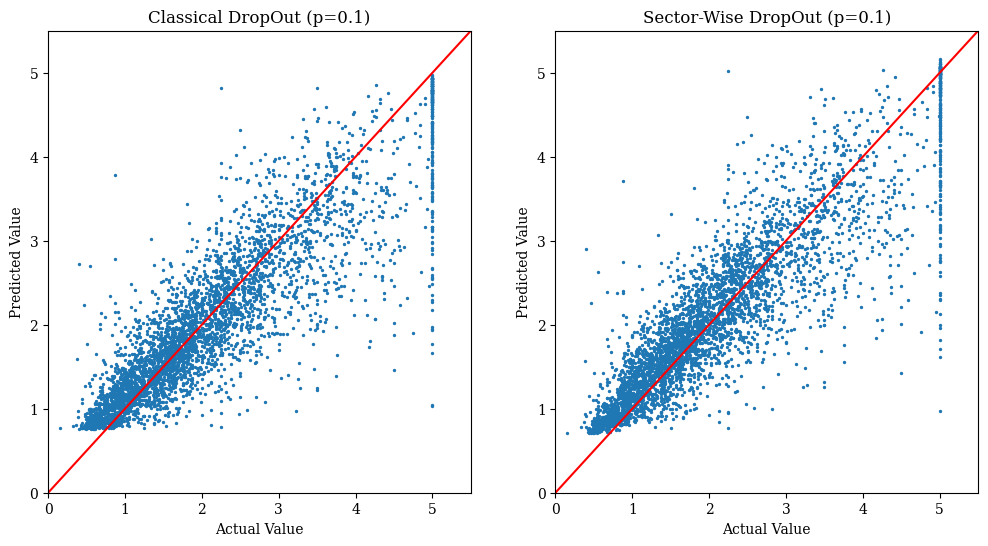

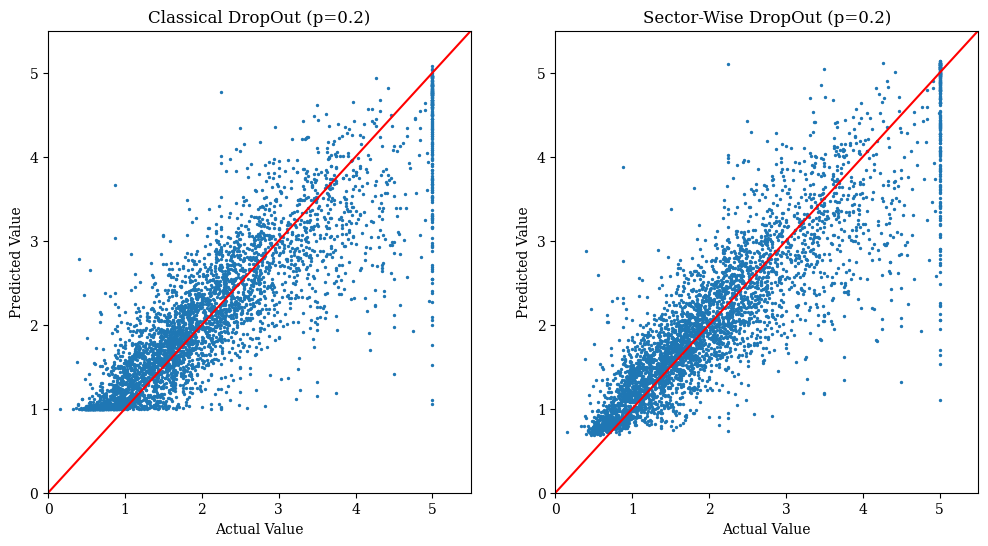

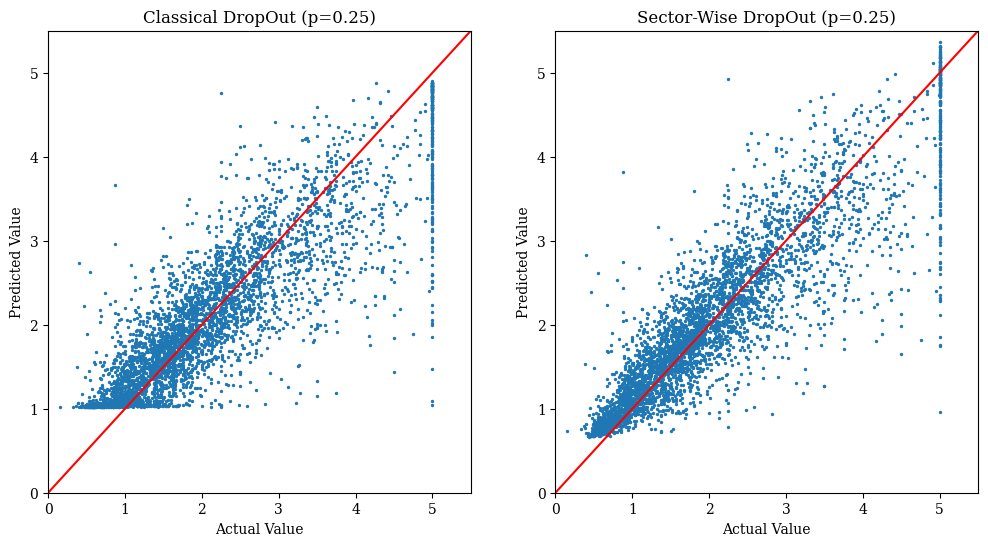

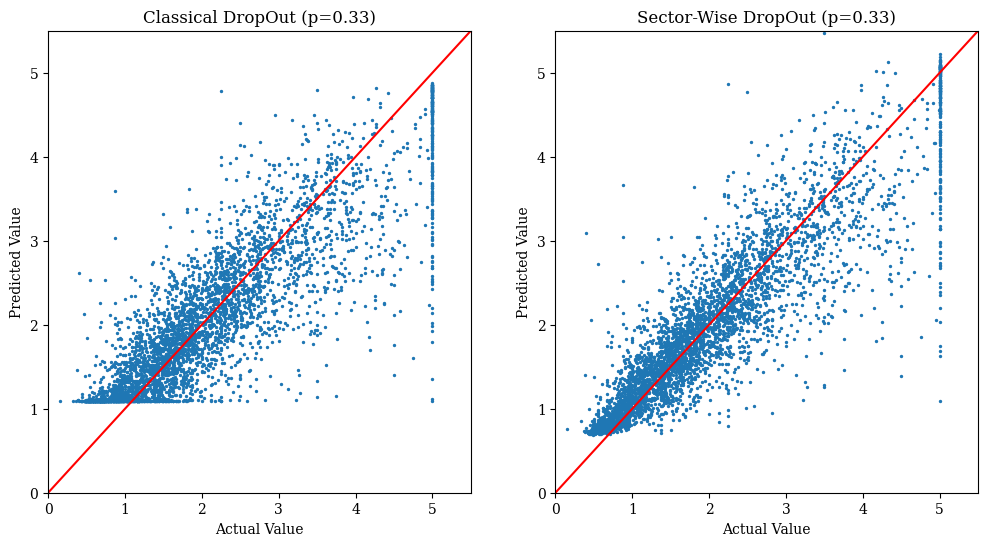

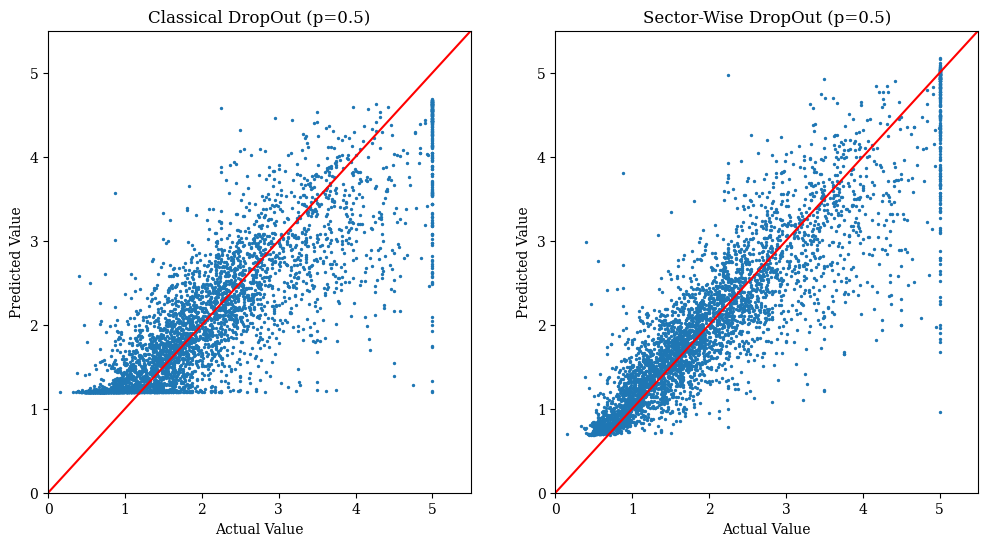

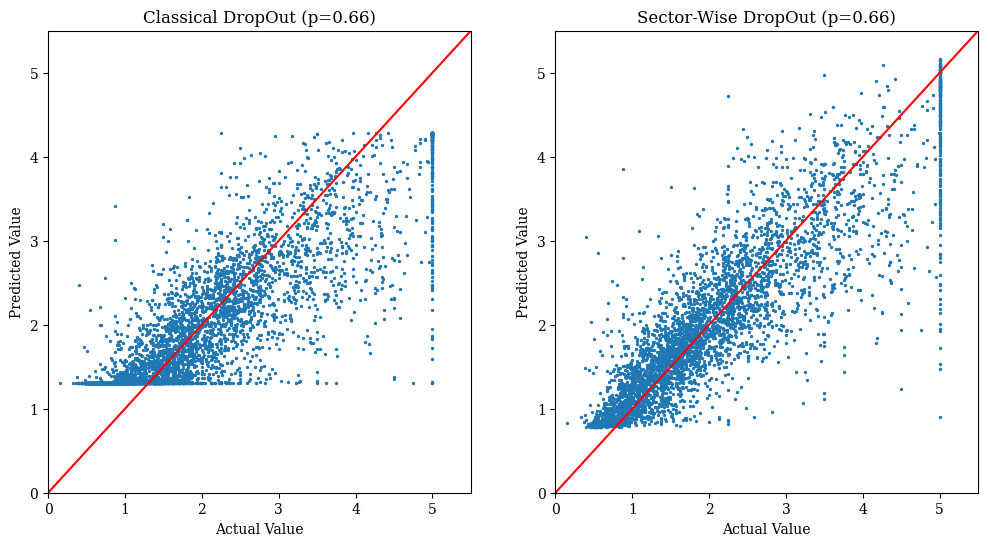

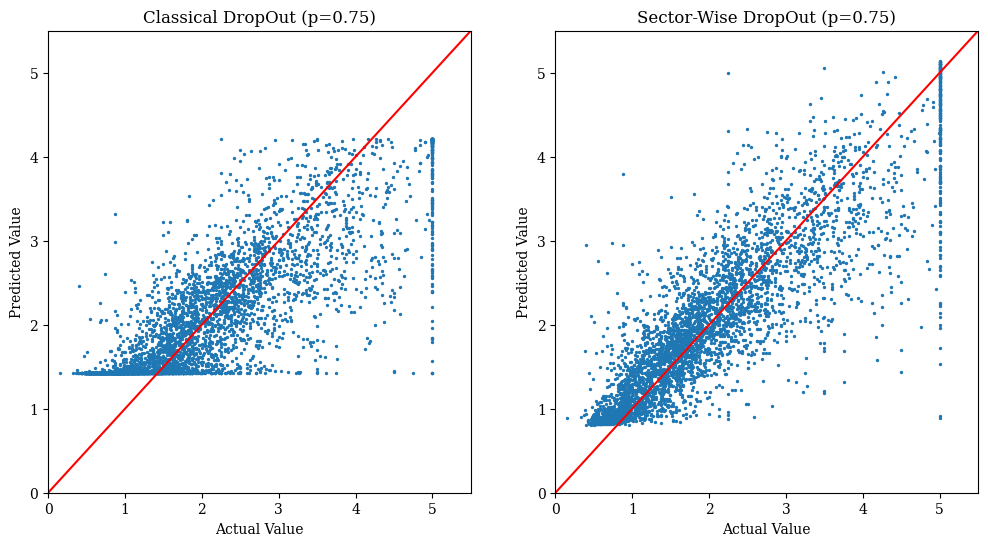

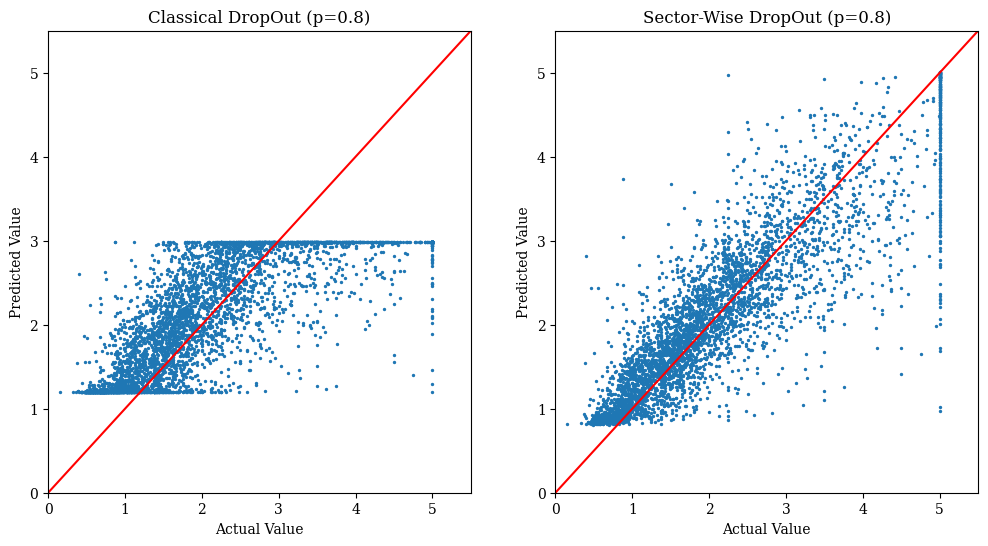

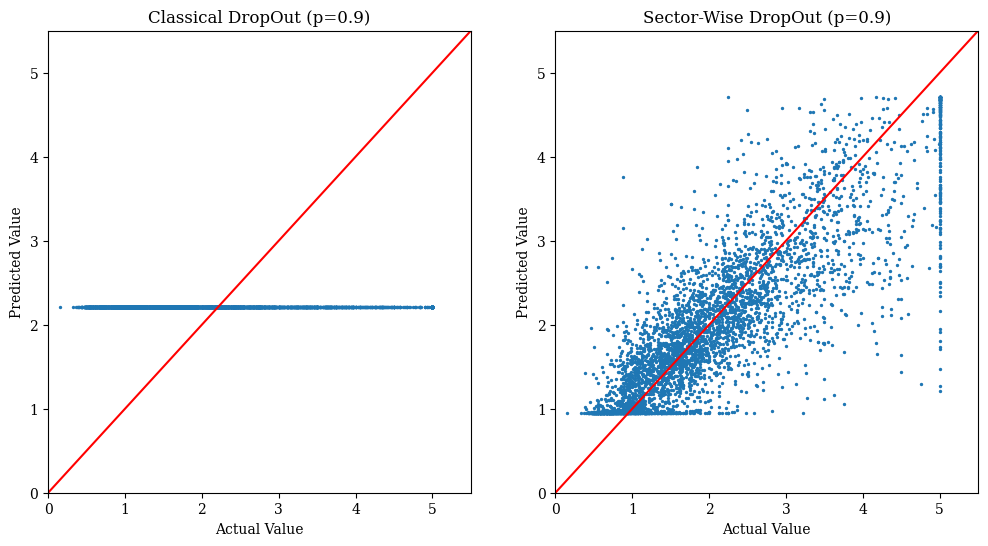

In [159]:
predGraph(y_pred_dropout90,y_pred_swdo90,y_true,0.1)
predGraph(y_pred_dropout80,y_pred_swdo80,y_true,0.2)
predGraph(y_pred_dropout75,y_pred_swdo75,y_true,0.25)
predGraph(y_pred_dropout66,y_pred_swdo66,y_true,0.33)
predGraph(y_pred_dropout50,y_pred_swdo50,y_true,0.5)
predGraph(y_pred_dropout33,y_pred_swdo33,y_true,0.66)
predGraph(y_pred_dropout25,y_pred_swdo25,y_true,0.75)
predGraph(y_pred_dropout20,y_pred_swdo20,y_true,0.8)
predGraph(y_pred_dropout10,y_pred_swdo10,y_true,0.9)



In [ ]:
overlayGraphs(t_loss_dropout90,v_loss_dropout90,t_loss_swdo90,v_loss_swdo90,epochs,0.1)
overlayGraphs(t_loss_dropout80,v_loss_dropout80,t_loss_swdo80,v_loss_swdo80,epochs,0.2)
overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75,v_loss_swdo75,epochs,0.25)
overlayGraphs(t_loss_dropout66,v_loss_dropout66,t_loss_swdo66,v_loss_swdo66,epochs,0.33)
overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50,v_loss_swdo50,epochs,0.5)
overlayGraphs(t_loss_dropout33,v_loss_dropout33,t_loss_swdo33,v_loss_swdo33,epochs,0.66)
overlayGraphs(t_loss_dropout25,v_loss_dropout25,t_loss_swdo25,v_loss_swdo25,epochs,0.75)
overlayGraphs(t_loss_dropout20,v_loss_dropout20,t_loss_swdo20,v_loss_swdo20,epochs,0.8)
overlayGraphs(t_loss_dropout10,v_loss_dropout10,t_loss_swdo10,v_loss_swdo10,epochs,0.9)

In [ ]:

epochs = range(250)
third_layer_size = 30
dropout_rate = .50
group_size=10
drop_per_group=5

# t_loss_dropout50, v_loss_dropout10, tst_loss_dropout10, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
t_loss_swdo50v3,    v_loss_swdo50v3,    tst_loss_swdo50v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)

print("SWDO Test Loss = ",tst_loss_swdo50v3)
print("  DO Test Loss = ",tst_loss_dropout50)

# overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50v3,v_loss_swdo50v3,epochs)

   

In [ ]:
all_sector = [tst_loss_swdo90,tst_loss_swdo80,tst_loss_swdo75,tst_loss_swdo66,tst_loss_swdo50,tst_loss_swdo33,tst_loss_swdo25,tst_loss_swdo20]
all_do = [tst_loss_dropout90,tst_loss_dropout80,tst_loss_dropout75,tst_loss_dropout66,tst_loss_dropout50,tst_loss_dropout33,tst_loss_dropout25,tst_loss_dropout20]
plt.title('Varying Sector Size with p=0.5')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.ylim([0.45,1.5])
plt.plot(epochs,v_loss_dropout50,'y',label='Bernoulli')
plt.plot(epochs,v_loss_swdo50,'r',label='1/2')
plt.plot(epochs,v_loss_swdo50v2,'g',label='5/10')
plt.plot(epochs,v_loss_swdo50v3,'b',label='10/20')
plt.legend()
plt.show


In [ ]:
all_sector = [tst_loss_swdo90,tst_loss_swdo80,tst_loss_swdo75,tst_loss_swdo66,tst_loss_swdo50,tst_loss_swdo50,tst_loss_swdo25,tst_loss_swdo20]
all_do = [tst_loss_dropout90,tst_loss_dropout80,tst_loss_dropout75,tst_loss_dropout66,tst_loss_dropout50,tst_loss_dropout50,tst_loss_dropout25,tst_loss_dropout20]
plt.title('Effect of Dropout Rate on Test Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.ylim([0.25,.8])
plt.plot(all_sector,)
# plt.plot(epochs,v_loss_dropout75,'y',label='Bernoulli')
# plt.plot(epochs,v_loss_swdo75v1,'r',label='3/4')
# plt.plot(epochs,v_loss_swdo75v2,'g',label='9/12')
# plt.plot(epochs,v_loss_swdo75v3,'b',label='18/24')
plt.legend()
plt.show

In [136]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .1
group_size=10
drop_per_group=1

t_loss_dropout10, v_loss_dropout10, tst_loss_dropout10, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo10v1,    v_loss_swdo10v1,    tst_loss_swdo10v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=20
# drop_per_group=2
# t_loss_swdo10v2,    v_loss_swdo10v2,    tst_loss_swdo10v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

# group_size=30
# drop_per_group=3
# t_loss_swdo10v3,    v_loss_swdo10v3,    tst_loss_swdo10v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [157]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .2
group_size=5
drop_per_group=1

t_loss_dropout20, v_loss_dropout20, tst_loss_dropout20, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo20v1,    v_loss_swdo20v1,    tst_loss_swdo20v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

group_size=15
drop_per_group=3
# t_loss_swdo20v2,    v_loss_swdo20v2,    tst_loss_swdo20v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

group_size=30
drop_per_group=6
# t_loss_swdo20v3,    v_loss_swdo20v3,    tst_loss_swdo20v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [138]:
epochs = range(300)
first_layer_size = 64
second_layer_size = 64
third_layer_size = 32
dropout_rate = .25
group_size=4
drop_per_group=1

t_loss_dropout25, v_loss_dropout25, tst_loss_dropout25, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo25v1,    v_loss_swdo25v1,    tst_loss_swdo25v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=16
# drop_per_group=4
# t_loss_swdo25v2,    v_loss_swdo25v2,    tst_loss_swdo25v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

# group_size=32
# drop_per_group=8
# t_loss_swdo25v3,    v_loss_swdo25v3,    tst_loss_swdo25v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [139]:
epochs = range(300)
first_layer_size = 72
second_layer_size = 72
third_layer_size = 36
dropout_rate = .33
group_size=3
drop_per_group=1

t_loss_dropout33, v_loss_dropout33, tst_loss_dropout33, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo33v1,    v_loss_swdo33v1,    tst_loss_swdo33v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout33,v_loss_dropout33,t_loss_swdo33v1,v_loss_swdo33v1,epochs)

# group_size=9
# drop_per_group=3
# t_loss_swdo33v2,    v_loss_swdo33v2,    tst_loss_swdo33v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout33,v_loss_dropout33,t_loss_swdo33v2,v_loss_swdo33v2,epochs)

# group_size=18
# drop_per_group=6
# t_loss_swdo33v3,    v_loss_swdo33v3,    tst_loss_swdo33v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout33,v_loss_dropout33,t_loss_swdo33v3,v_loss_swdo33v3,epochs)



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [140]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .5
group_size=2
drop_per_group=1

t_loss_dropout50, v_loss_dropout50, tst_loss_dropout50, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo50v1,    v_loss_swdo50v1,    tst_loss_swdo50v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50v1,v_loss_swdo50v1,epochs)

# group_size=10
# drop_per_group=5
# t_loss_swdo50v2,    v_loss_swdo50v2,    tst_loss_swdo50v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50v2,v_loss_swdo50v2,epochs)

# group_size=30
# drop_per_group=15
# t_loss_swdo50v3,    v_loss_swdo50v3,    tst_loss_swdo50v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout50,v_loss_dropout50,t_loss_swdo50v3,v_loss_swdo50v3,epochs)

print("SWDO Test Loss = ",tst_loss_swdo50v3)
print("  DO Test Loss = ",tst_loss_dropout50)



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [141]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .66
group_size=3
drop_per_group=2

t_loss_dropout66, v_loss_dropout66, tst_loss_dropout66, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo25v1,    v_loss_swdo25v1,    tst_loss_swdo25v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=15
# drop_per_group=10
# t_loss_swdo66v2,    v_loss_swdo66v2,    tst_loss_swdo66v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

# group_size=30
# drop_per_group=20
# t_loss_swdo66v3,    v_loss_swdo66v3,    tst_loss_swdo66v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [142]:
epochs = range(300)
first_layer_size = 64
second_layer_size = 64
third_layer_size = 32
dropout_rate = .75
group_size=3
drop_per_group=2

t_loss_dropout75, v_loss_dropout75, tst_loss_dropout75, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo25v1,    v_loss_swdo25v1,    tst_loss_swdo25v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=15
# drop_per_group=10
# t_loss_swdo66v2,    v_loss_swdo66v2,    tst_loss_swdo66v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

# group_size=30
# drop_per_group=20
# t_loss_swdo66v3,    v_loss_swdo66v3,    tst_loss_swdo66v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [143]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .8
group_size=5
drop_per_group=4

t_loss_dropout80, v_loss_dropout80, tst_loss_dropout80, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo25v1,    v_loss_swdo25v1,    tst_loss_swdo25v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=15
# drop_per_group=12
# t_loss_swdo80v2,    v_loss_swdo80v2,    tst_loss_swdo80v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

# group_size=30
# drop_per_group=24
# t_loss_swdo80v3,    v_loss_swdo80v3,    tst_loss_swdo80v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [144]:
epochs = range(300)
first_layer_size = 60
second_layer_size = 60
third_layer_size = 30
dropout_rate = .9
group_size=10
drop_per_group=9

t_loss_dropout90, v_loss_dropout90, tst_loss_dropout90, _ = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_swdo25v1,    v_loss_swdo25v1,    tst_loss_swdo25v1,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v1,v_loss_swdo75v1,epochs)

# group_size=20
# drop_per_group=18
# t_loss_swdo90v2,    v_loss_swdo90v2,    tst_loss_swdo90v2,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v2,v_loss_swdo75v2,epochs)

group_size=30
drop_per_group=27
# t_loss_swdo90v3,   v_loss_swdo90v3,    tst_loss_swdo90v3,    _    = train_and_test_sw_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# overlayGraphs(t_loss_dropout75,v_loss_dropout75,t_loss_swdo75v3,v_loss_swdo75v3,epochs)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

In [135]:
def constantP(epochs,   t_loss_do1, t_loss_sw1, val_loss_do1,   val_loss_sw1,d1,g1, 
                        t_loss_sw3, val_loss_sw3,d3,g3,drop_rate,**kwargs):
    fig, (ax11,ax12) = plt.subplots(1,2)
    fig.set_figwidth(12)
    fig.set_figheight(6)
    
    ax11.set_title('Comparison of Training Losses at p={:.2f}'.format(drop_rate))
    ax11.plot(epochs,t_loss_do1,'y',label='Classical')
    ax11.plot(epochs, t_loss_sw1, 'r', label=f'{d1}/{g1}')
    if kwargs.keys().__contains__('t_loss_sw2'):
        ax11.plot(epochs,kwargs['t_loss_sw2'],'g',label=f'{kwargs["d2"]}/{kwargs["g2"]}')
    ax11.plot(epochs, t_loss_sw3, 'b', label=f'{d3}/{g3}')
    ax11.set_ylim(0.25, .65)
    ax11.set(xlabel='Epochs',ylabel='Training Loss')
    ax11.legend()
    
    ax12.set_title('Comparison of Validation Losses at p={:.2f}'.format(drop_rate))
    ax12.plot(epochs,val_loss_do1,'y',label='Classical')
    ax12.plot(epochs, val_loss_sw1, 'r', label=f'{d1}/{g1}')
    if kwargs.keys().__contains__('val_loss_sw2'):
        ax12.plot(epochs,kwargs['val_loss_sw2'],'g',label=f'{kwargs["d2"]}/{kwargs["g2"]}')
    ax12.plot(epochs, val_loss_sw3, 'b', label=f'{d3}/{g3}')
    ax12.set(xlabel='Epochs',ylabel='Validation Loss')
    ax12.set_ylim(0.25, .65)
    ax12.legend()
    
    plt.show()


In [156]:
print("{:.2f} {:.2f}".format(v_loss_dropout10[-1], tst_loss_swdo10))
print("{:.2f} {:.2f}".format(v_loss_dropout20[-1], tst_loss_swdo20))
print("{:.2f} {:.2f}".format(v_loss_dropout25[-1], tst_loss_swdo25))
print("{:.2f} {:.2f}".format(v_loss_dropout33[-1], tst_loss_swdo33))
print("{:.2f} {:.2f}".format(v_loss_dropout50[-1], tst_loss_swdo50))
print("{:.2f} {:.2f}".format(v_loss_dropout66[-1], tst_loss_swdo66))
print("{:.2f} {:.2f}".format(v_loss_dropout75[-1], tst_loss_swdo75))
print("{:.2f} {:.2f}".format(v_loss_dropout80[-1], tst_loss_swdo80))
print("{:.2f} {:.2f}".format(v_loss_dropout90[-1], tst_loss_swdo90))
print(t_loss_dropout20[-1], t_loss_swdo20[-1], v_loss_dropout20[-1], v_loss_swdo20[-1])

0.29 0.38
5.64 0.33
0.32 0.34
0.33 0.33
0.36 0.29
0.40 0.28
0.44 0.29
0.49 0.31
1.37 0.30
5.558525254730511 0.31455042963814694 5.6408930922396845 0.30829916544330016


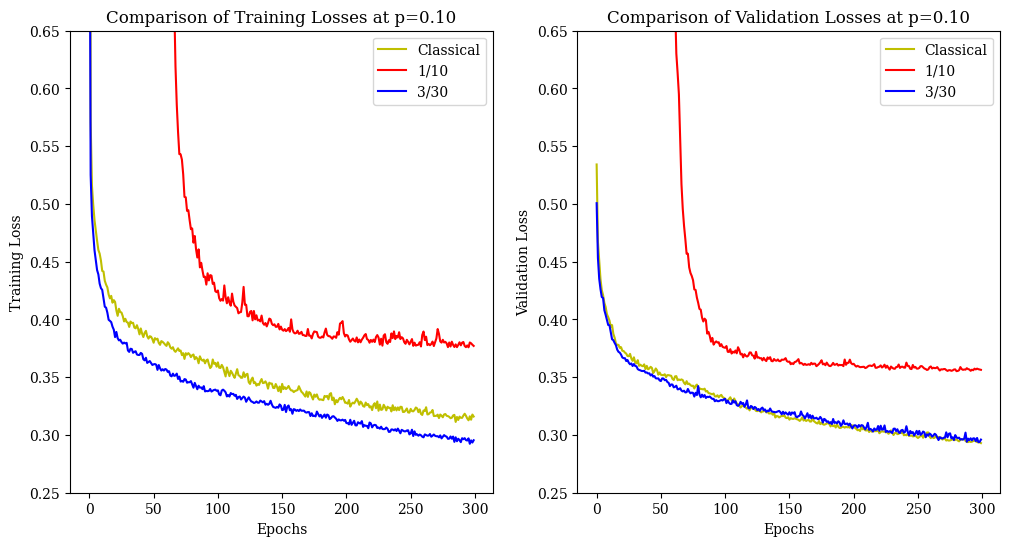

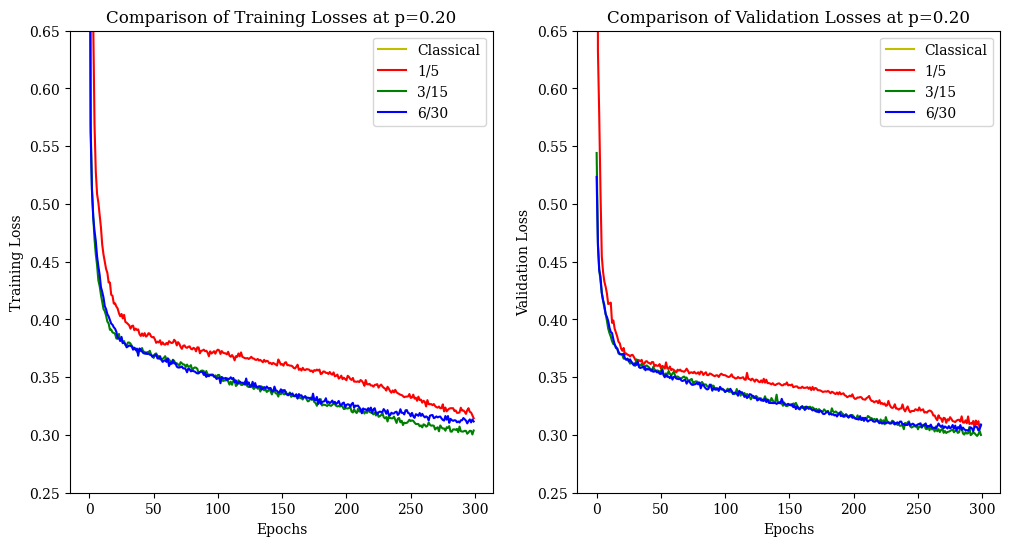

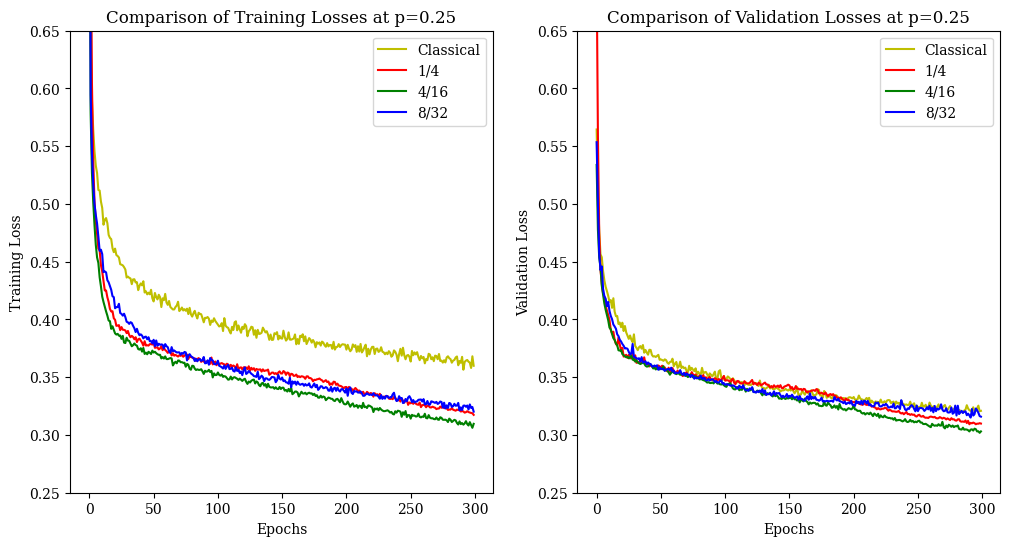

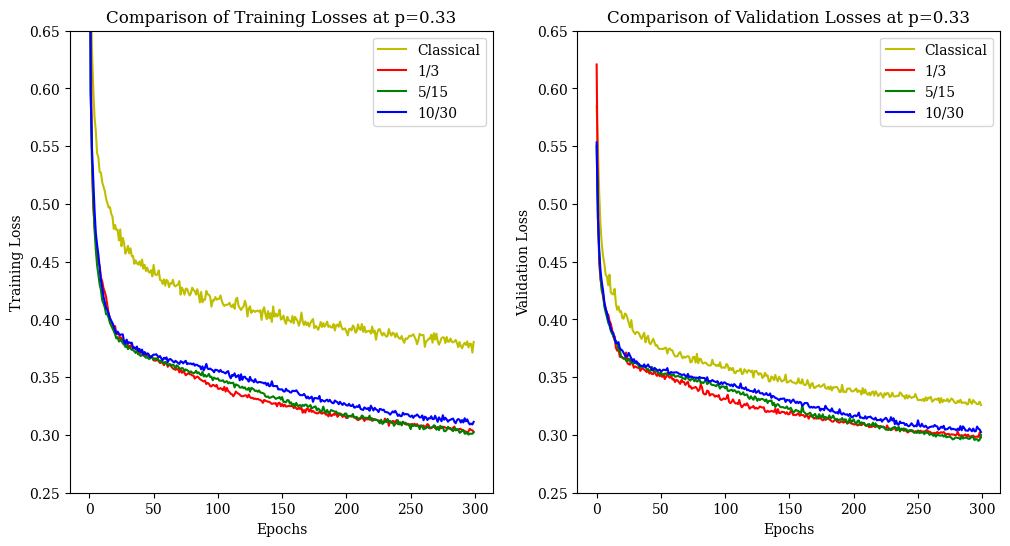

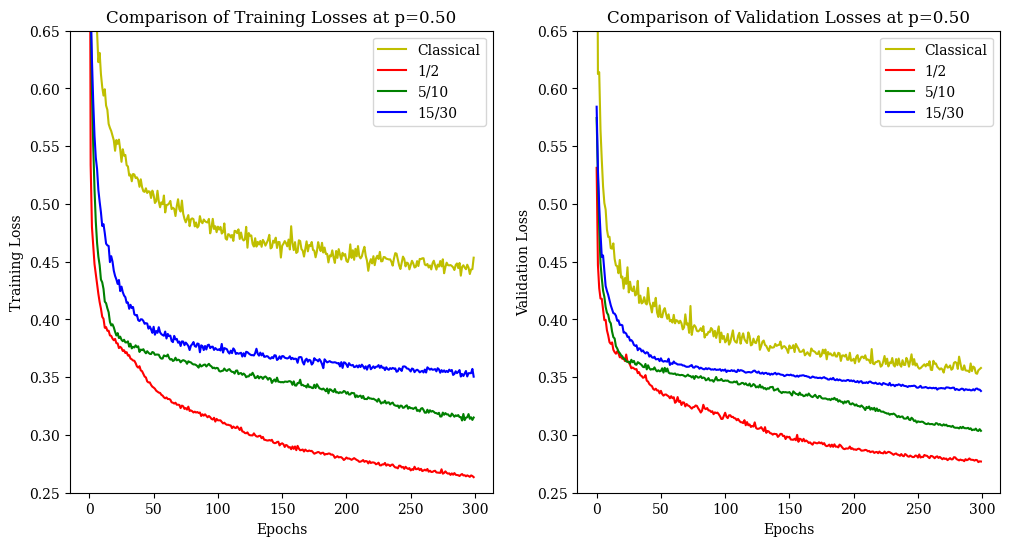

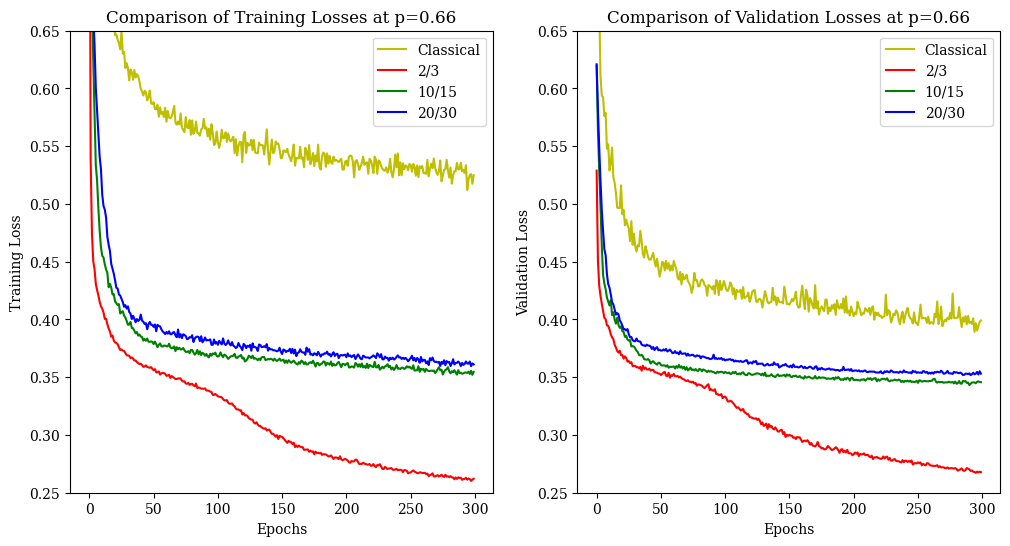

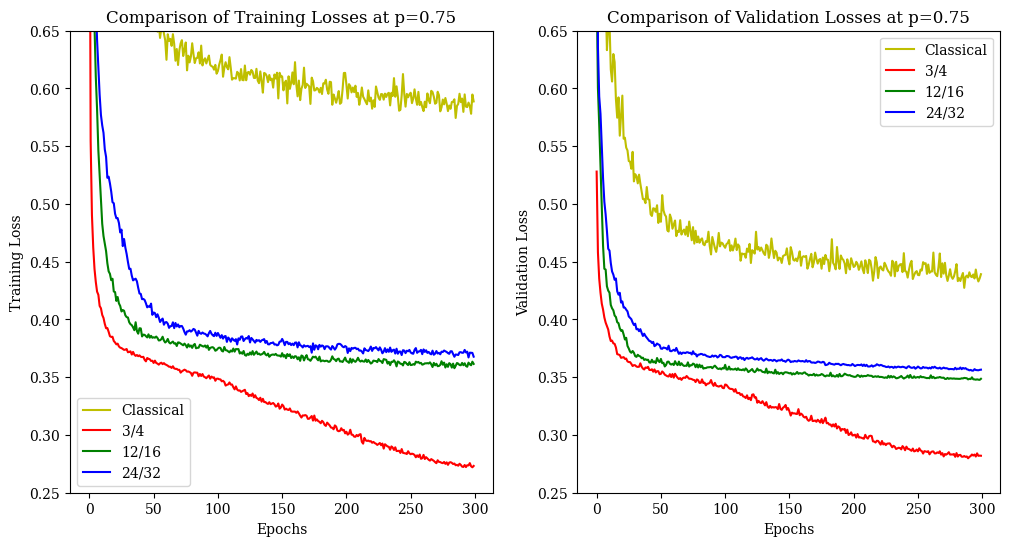

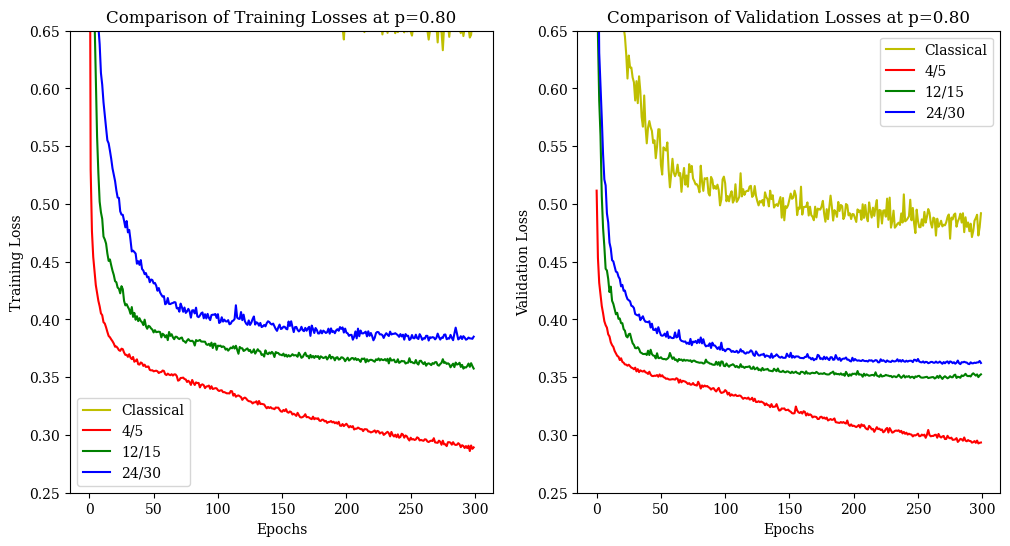

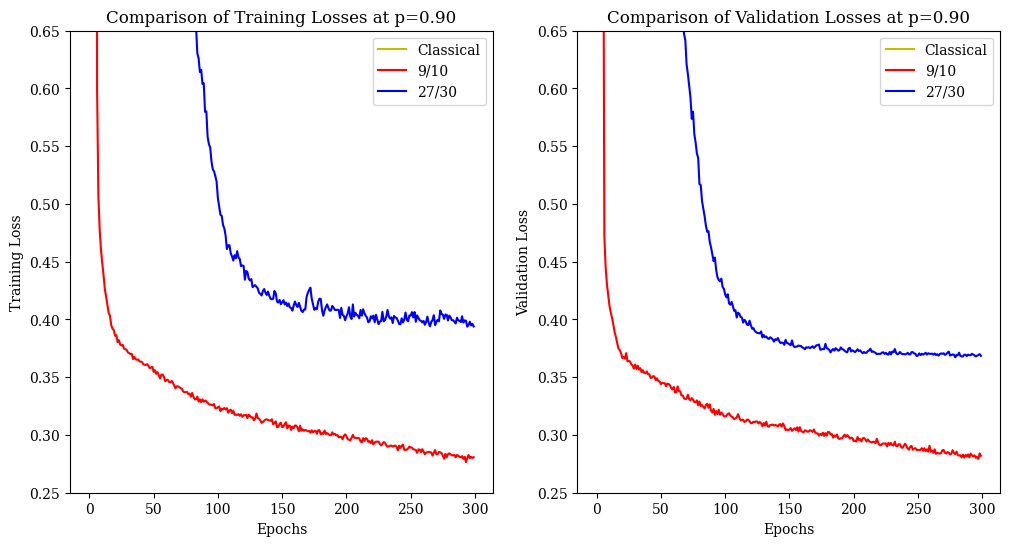

In [154]:
constantP(epochs, t_loss_dropout10, t_loss_swdo10, v_loss_dropout10, v_loss_swdo10, 1,10, t_loss_swdo10v3,v_loss_swdo10v3,3 ,30, 0.10 )
constantP(epochs, t_loss_dropout20, t_loss_swdo20, v_loss_dropout20, v_loss_swdo20, 1,5,  t_loss_swdo20v3,v_loss_swdo20v3,6 ,30, 0.20,t_loss_sw2=t_loss_swdo20v2,val_loss_sw2=v_loss_swdo20v2,d2=3,g2=15 )
constantP(epochs, t_loss_dropout25, t_loss_swdo25, v_loss_dropout25, v_loss_swdo25, 1,4,  t_loss_swdo25v3,v_loss_swdo25v3,8 ,32, 0.25,t_loss_sw2=t_loss_swdo25v2,val_loss_sw2=v_loss_swdo25v2,d2=4,g2=16 )
constantP(epochs, t_loss_dropout33, t_loss_swdo33, v_loss_dropout33, v_loss_swdo33, 1,3,  t_loss_swdo33v3,v_loss_swdo33v3,10,30, 0.33,t_loss_sw2=t_loss_swdo33v2,val_loss_sw2=v_loss_swdo33v2,d2=5,g2=15 )
constantP(epochs, t_loss_dropout50, t_loss_swdo50, v_loss_dropout50, v_loss_swdo50, 1,2,  t_loss_swdo50v3,v_loss_swdo50v3,15,30, 0.50,t_loss_sw2=t_loss_swdo50v2,val_loss_sw2=v_loss_swdo50v2,d2=5,g2=10 )
constantP(epochs, t_loss_dropout66, t_loss_swdo66, v_loss_dropout66, v_loss_swdo66, 2,3,  t_loss_swdo66v3,v_loss_swdo66v3,20,30, 0.66,t_loss_sw2=t_loss_swdo66v2,val_loss_sw2=v_loss_swdo66v2,d2=10,g2=15 )
constantP(epochs, t_loss_dropout75, t_loss_swdo75, v_loss_dropout75, v_loss_swdo75, 3,4,  t_loss_swdo75v3,v_loss_swdo75v3,24,32, 0.75,t_loss_sw2=t_loss_swdo75v2,val_loss_sw2=v_loss_swdo75v2,d2=12,g2=16 )
constantP(epochs, t_loss_dropout80, t_loss_swdo80, v_loss_dropout80, v_loss_swdo80, 4,5,  t_loss_swdo80v3,v_loss_swdo80v3,24,30, 0.80,t_loss_sw2=t_loss_swdo80v2,val_loss_sw2=v_loss_swdo80v2,d2=12,g2=15 )
constantP(epochs, t_loss_dropout90, t_loss_swdo90, v_loss_dropout90, v_loss_swdo90, 9,10, t_loss_swdo90v3,v_loss_swdo90v3,27,30, 0.90)


In [ ]:
all_sector = [tst_loss_swdo10,tst_loss_swdo20,tst_loss_swdo25,tst_loss_swdo33,tst_loss_swdo50,tst_loss_swdo66,tst_loss_swdo75,tst_loss_swdo80,tst_loss_swdo90]
# all_sector = [tst_loss_swdo90,tst_loss_swdo80,tst_loss_swdo75,tst_loss_swdo66,tst_loss_swdo50,tst_loss_swdo33,tst_loss_swdo25,tst_loss_swdo20]
all_do = [tst_loss_dropout10,tst_loss_dropout20,tst_loss_dropout25,tst_loss_dropout33,tst_loss_dropout50,tst_loss_dropout66,tst_loss_dropout75,tst_loss_dropout80,tst_loss_dropout90]
# all_do = [tst_loss_dropout90,tst_loss_dropout80,tst_loss_dropout75,tst_loss_dropout66,tst_loss_dropout50,tst_loss_dropout33,tst_loss_dropout25,tst_loss_dropout20]
plt.title('Effect of Dropout Rate on Test Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Test Loss')
plt.plot([.1,.2,.25,.33,.5,.66,.75,.8,.9],all_do, 'b',label='Classical Dropout')
# plt.plot([.1,.2,.25,.33,.5,.66,.75,.8],all_do, 'b',label='Classical Dropout')
plt.plot([.1,.2,.25,.33,.5,.66,.75,.8,.9],all_sector,'g', label='Sector-Wise Dropout')
# plt.plot([.1,.2,.25,.33,.5,.66,.75,.8],all_sector,'g', label='Sector-Wise Dropout')
# plt.ylim([.25,.80])
plt.legend()
plt.show
